# Test Set

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [63]:
amazon = pd.read_csv('/Users/andrewlevinson/programs/parsons/spring-2019/machine-learning-class/machine-learning/assignment-1/data/raw_data_test.csv')

print(amazon.shape)

(91000, 14)


In [64]:
print(amazon.loc[0, "Text"])

As much as I love Italian Sweet Creme in liquid form ( the only one I use ) , this one is not even closer to the taste of the liquid, I have strange after taste like chemical or something , plus I get flux-reflect if I use to often , very disappointed and will not purchase again .


In [65]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      450430        317629  317630  B002BUD5TK   AZ4EUUJVC8358   
1      209527        289838  289839  B003LPOUZM  A1BEU8FCL6JI4T   
2      329547        479010  479011  B001E5E074  A1XL72EEATTQY4   
3       46044        256379  256380  B001EQ55R2  A38XAAS5U05GY8   
4      162804        355065  355066  B001EQ4OBA   A6S4BCIF87GQ7   

                     ProfileName  HelpfulnessNumerator  \
0                          Kasia                     1   
1                 Linda "ln5229"                     0   
2  Michael J. Pruett "M P buyer"                     2   
3                         Judith                     0   
4            Reason "books_easy"                     1   

   HelpfulnessDenominator  Score        Time  \
0                       1      1  1340755200   
1                       0      5  1298851200   
2                       2      3  1343692800   
3                       0      5  1320451200   
4       

### Feature extraction on natural language data

In [66]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [67]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/Users/andrewlevinson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 262144)


In [68]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [69]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [70]:
# features from Amazon.csv to add to feature set
# review word length
amazon['reviewLen'] = amazon['Text'].apply(lambda x: len(str(x).split(" ")))

# summary word length
amazon['sumLen'] = amazon['Summary'].apply(lambda x: len(str(x).split(" ")))

# upper case words in Text review
amazon['upper'] = amazon['Text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

# lower case words in Text review
amazon['lower'] = amazon['Text'].apply(lambda x: len([x for x in x.split() if x.islower()]))

#count freq of specific words
amazon['special'] = amazon['Text'].str.count("love") + amazon['Text'].str.count("price") + amazon['Text'].str.count("easy") + amazon['Text'].str.count("loves")  + amazon['Text'].str.count("recommend") + amazon['Text'].str.count("happy") + amazon['Text'].str.count("disappointed")

X_quant_features = amazon[["Score", "reviewLen", "Time", "sumLen", "upper", "lower", "special"]]
print(X_quant_features.head(25))
# print(type(X_quant_features))

    Score  reviewLen        Time  sumLen  upper  lower  special
0       1         59  1340755200       3      5     44        2
1       5         29  1298851200       3      0     23        0
2       3         23  1343692800       1      2     14        0
3       5         42  1320451200       4      1     38        0
4       3         48  1290384000       6      4     40        1
5       1        116  1251504000       3      5     93        0
6       4         18  1214092800       3      0     13        0
7       5         61  1347667200       5      7     49        1
8       5         92  1318118400       3      0     80        1
9       1         62  1340150400       4      5     46        1
10      5         16  1261008000       2      2     13        1
11      5        134  1206921600       2      1    119        0
12      4         79  1312329600       2      3     73        0
13      5         46  1334188800       7      0     37        0
14      5        109  1326844800       5

### Combine all quantitative features into a single sparse matrix

In [71]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 262151)


### Create `X`, scaled matrix of features

In [72]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 262151)


### create `y`, vector of Labels

In [73]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [74]:
# MODEL: ordinary least squares
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X, y)
# joblib.dump(ols, 'ols.pkl') # pickle
ols = joblib.load('ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 3099, 'TN': 46648, 'FP': 37644, 'FN': 3609, 'Accuracy': 0.5466703296703297, 'Precision': 0.07606214564465061, 'Recall': 0.4619856887298748, 'desc': 'ols'}


In [75]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 1987, 'TN': 79279, 'FP': 5013, 'FN': 4721, 'Accuracy': 0.8930329670329671, 'Precision': 0.28385714285714286, 'Recall': 0.2962134764460346, 'desc': 'svm'}


In [76]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 1482, 'TN': 81238, 'FP': 3054, 'FN': 5226, 'Accuracy': 0.909010989010989, 'Precision': 0.32671957671957674, 'Recall': 0.22093023255813954, 'desc': 'lgs'}


In [77]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 2520, 'TN': 73300, 'FP': 10992, 'FN': 4188, 'Accuracy': 0.8331868131868132, 'Precision': 0.18650088809946713, 'Recall': 0.3756708407871199, 'desc': 'nbs'}


In [78]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 2262, 'TN': 77824, 'FP': 6468, 'FN': 4446, 'Accuracy': 0.880065934065934, 'Precision': 0.259106529209622, 'Recall': 0.3372093023255814, 'desc': 'prc'}


In [79]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 166, 'TN': 84139, 'FP': 153, 'FN': 6542, 'Accuracy': 0.9264285714285714, 'Precision': 0.5203761755485894, 'Recall': 0.024746571258199165, 'desc': 'rdg'}


In [80]:
# MODEL: Decision Tree Classifier
# from sklearn import tree
# dtc = tree.DecisionTreeClassifier(max_depth=100)
# dtc.fit(X_matrix, y)
# joblib.dump(dtc, 'dtc.pkl') # pickle
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 2823, 'TN': 81079, 'FP': 3213, 'FN': 3885, 'Accuracy': 0.922, 'Precision': 0.4676938369781312, 'Recall': 0.4208407871198569, 'desc': 'dtc'}


### ROC plot to compare performance of various models and fits

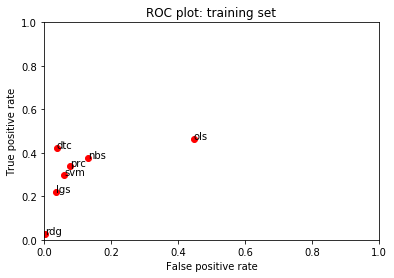

In [81]:
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance, ols_performance, dtc_performance, nbs_performance]
# fits = [svm_performance, lgs_performance, rdg_performance, prc_performance, ols_performance, nbs_performance]

# fits = [rdg_performance, ols_performance, dtc_performance, nbs_performance]
# fits = [rdg_performance, dtc_performance]




for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [18]:
amazon.loc[0, "Text"]

'As much as I love Italian Sweet Creme in liquid form ( the only one I use ) , this one is not even closer to the taste of the liquid, I have strange after taste like chemical or something , plus I get flux-reflect if I use to often , very disappointed and will not purchase again .'

In [19]:
amazon.loc[0, "helpful"]

False

In [20]:
ridge_predictions = rdg.predict(X)

In [21]:
ridge_predictions.shape

(91000,)

In [22]:
print(ridge_predictions)

[False False False ... False False False]


In [23]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

1529
2008-12-20 00:00:00
5
0
B0006U7T12
We have a wonderful German shepherd in our family.  She's happy and affectionate and a wonderful companion.  Exactly the kind of dog that one enjoys rewarding for her good behavior.<br /><br />And our dog, Asha, seems to look at 7.4 ounce Jumbones as something to which she is entitled.  In short, she loves these treats! She weighs more than she should, so perhaps we are being overindulgent with her, but she loves these so much that it's hard not to provide a supply to last the week for her.<br /><br />For me? I don't know how good these really are.  But, trust me, my dog loves them.
* * * * * * * * * 
5409
2010-09-23 00:00:00
1
21
B002OMB1C8
Mimosa pudica, while fun, is an invasive alien in many countries and toxic to wildlife and grazing animals. Mimosa trees have been banned in Florida. Mimosa trees are banned in many areas because of short lives, branches breaking easily, tendencies to invade and harm native species.<br /><br /><a href="http:/

86568
2012-04-22 00:00:00
5
0
B004F1LNDI
The Stinger Waffles taste great and have been a life saver more than once when I've "bonked" on a long ride or hike. I like the vanilla ones a little better, but both taste great.
* * * * * * * * * 
87079
2009-09-22 00:00:00
5
0
B000SW4NNK
This is a nice small bottle of minced garlic with a wonderful rich, full aroma.  The garlic itself is very mild though.  It has absolutely no BITE!  unlike some fresh garlic bulbs.  This is great for some recipes but others...like hummus... would benefit from a more aggressive tangy taste.  Being prepared and bottled, there are no bulbs to go bad with excessive time and no mess of peeling and mincing.  I really like these Goya minced garlic bottles and highly recommend them to anyone who enjoys a milder garlic flavor. I will be buying them again!
* * * * * * * * * 
88519
2012-08-30 00:00:00
5
0
B004XTDU8I
Badshah Punjabi Garam Masala.<br />Garam Masala is a quintessential ingredient in various dishes of Indian